# Car Recognition with Deep Learning

This tutorial shows how Deep Neural Networks are used to recognize cars on images versus images with no cars on them (binary classification).

In [1]:
import os
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=' + device + ',floatX=float32,nvcc.flags=-D_FORCE_INLINES'

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np

from PIL import Image
from theano import config

from sklearn import preprocessing
from sklearn.cross_validation import ShuffleSplit, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.optimizers import SGD, RMSprop, Adagrad
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD

Using Theano backend.


In [5]:
# needed?
import keras

import pandas as pd # Pandas for easier Data handling in preparation

from theano import function as tfunction

from keras.preprocessing import image
from keras.callbacks import Callback, History, EarlyStopping, ModelCheckpoint # BaseLogger,

import json
#import cPickle # for saving scaler and labelencoder

## Load the Images from Training Set

In [50]:
path = 'data/CarData/TrainImages'
files = glob.glob(os.path.join(path, '*.pgm'))
print "Found", len(files), "files"

Found 1050 files


In [51]:
images = []
image_names = []

for filename in files:
    image_names.append(os.path.basename(filename))
    with Image.open(filename) as img:
        images.append(np.array(img))

neg-102.pgm


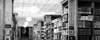

In [52]:
i=5
print image_names[i]
Image.fromarray(images[i])

In [53]:
type(images[i])

numpy.ndarray

In [54]:
images[i].shape   # height x width

(40, 100)

Note: Color RGB images have an additional dimension of depth 3, e.g. (40, 100, 3)

## Make 1 big array of list of images

In [55]:
# a list of many 40x100 images is made into 1 big array
# config.floatX is from Theano configration to enforce float32 precision (needed for GPU computation)
img_array = np.array(images, dtype=config.floatX)
img_array.shape

(1050, 40, 100)

## Create the Groundtruth based on filenames:

In this data set, images with cars start with "pos-" and images with no cars start with "neg-". We create a numeric list here containing 1 for car images and 0 for non-car images.

In [8]:
classes = []
for name in image_names:
    if name.startswith('neg'):
        classes.append(0)
    else:
        classes.append(1)

In [9]:
classes

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [10]:
print "Groundtruth Statistics:"

for v in set(classes):
    print "Class", v, ":", classes.count(v)

Groundtruth Statistics:
Class 0 : 500
Class 1 : 550


In [11]:
baseline = 550 * 1.0 / len(classes)
baseline

0.5238095238095238

## Standardization

<b>Always standardize</b> the data before feeding it into the Neural Network!

Here we use <b>Zero-mean Unit-variance standardization</b> (flat, i.e. one mean and std.dev. for the whole image is computed over all pixels; in RGB images, standardization can be done e.g. for each colour channel individually; in other/non-image data sets, attribute-wise standardization should be applied).

In [56]:
mean = img_array.mean()
stddev = img_array.std()
print mean, stddev

129.582 74.2767


In [13]:
img_array = (img_array - mean) / stddev
print img_array.mean(), img_array.std()

5.29858e-07 1.0


In [14]:
img_array.min(), img_array.max()

(-1.7445902, 1.6885179)

# TODO

In [65]:

# create folds
folds = 3
splits = StratifiedKFold(classes, n_folds=folds, shuffle=True, random_state=RANDOM_SEED)

    for train_ind, test_ind in splits:
        print "Train:", len(train_ind), "Test:", len(test_ind)


In [113]:
train_img = images[train_ind]
test_img = images[test_ind]

In [68]:
train_gt = groundtruth[train_ind]
test_gt = groundtruth[test_ind]

In [115]:
input_shape = images.shape[1:]
output_units = 1

multi_class = output_units > 1
multi_class

False

# Creating NN Models in Keras

## 1) Fully Connected NN

For a fully connected neural network, the images have to be flattened, as the x and y axis do not play a role. All pixels are considered as a completely individual input to the neural network.

In [15]:
#  flatten images to vectors
images_flat = img_array.reshape(img_array.shape[0],-1)
print images_flat.shape

(1050, 4000)


In [16]:
# find out input shape for NN, which is just a long vector (40x100 = 4000)
input_shape = images_flat.shape[1]
print input_shape

4000


### Creating a Model

In Keras, one can choose between a Sequential model and a Graph model. Sequential models are the standard case. Graph models are for parallel networks.

Here we create a sequential model with 2 fully connected (a.k.a. 'dense') layers containing 256 units each.

In [68]:
# simple Fully-connected network

model = Sequential()

model.add(Dense(256, input_dim=input_shape))

model.add(Dense(256))

model.add(Dense(1,activation='sigmoid'))



In [69]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 256)           1024256     dense_input_2[0][0]              
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 256)           65792       dense_4[0][0]                    
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 1)             257         dense_5[0][0]                    
Total params: 1,090,305
Trainable params: 1,090,305
Non-trainable params: 0
____________________________________________________________________________________________________


In [71]:
# Preparing / compiling the model
loss = 'binary_crossentropy' 
optimizer = 'sgd' #rmsprop'

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

### Training the model on the input dataset

In [72]:
epochs = 15
model.fit(images_flat, classes, batch_size=32, nb_epoch=epochs) #, validation_data=validation_data) 

Train on 1050 samples, validate on 170 samples
Epoch 1/15
1050/1050 [==============================] - 0s - loss: 0.5130 - acc: 0.7933 - val_loss: 4.3284 - val_acc: 0.0059
Epoch 2/15
1050/1050 [==============================] - 0s - loss: 0.3198 - acc: 0.8505 - val_loss: 1.2280 - val_acc: 0.4588
Epoch 3/15
1050/1050 [==============================] - 0s - loss: 0.2163 - acc: 0.9143 - val_loss: 2.1355 - val_acc: 0.2294
Epoch 4/15
1050/1050 [==============================] - 0s - loss: 0.1779 - acc: 0.9314 - val_loss: 1.7259 - val_acc: 0.3706
Epoch 5/15
1050/1050 [==============================] - 0s - loss: 0.1400 - acc: 0.9562 - val_loss: 2.3594 - val_acc: 0.2235
Epoch 6/15
1050/1050 [==============================] - 0s - loss: 0.1214 - acc: 0.9543 - val_loss: 1.5213 - val_acc: 0.4176
Epoch 7/15
1050/1050 [==============================] - 0s - loss: 0.1040 - acc: 0.9714 - val_loss: 1.3257 - val_acc: 0.4941
Epoch 8/15
1050/1050 [==============================] - 0s - loss: 0.0763 - ac

In [21]:
# verify Accuracy on Train set
predictions = model.predict_classes(images_flat)
accuracy_score(predictions, classes)

 960/1050 [==========================>...] - ETA: 0s

1.0

### 100% Accuracy - perfect, no?

This is the accuracy on the training set. A (large, especially fully connected network with sufficient number of units) can easily learn the entire training set (especially a small one like here).

This very likely leads to <b>overfitting</b>. That's why we test on an independent test set.


# Testing with Test Data Set

In [57]:
path = 'data/CarData/TestImages'
files = glob.glob(os.path.join(path, '*.pgm'))
print "Found", len(files), "files"

Found 170 files


In [58]:
from image_preprocessing import resize_and_crop

test_images = []

for filename in files:
    with Image.open(filename) as img:
        img_resized = resize_and_crop(img,target_width=100,target_height=40)
        test_images.append(np.array(img_resized))
        #print img.size, img_resized.size

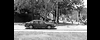

In [59]:
i=0
Image.fromarray(test_images[i])

In [60]:
# make 1 big array again from list
test_images = np.array(test_images)

### Standardize Test Set

The test data has to be standardized <b>in the same way</b> as the training data for compatibility with the model! That means, we take the mean and standard deviation of the <i>training data</i> to transform also the test data.

In [38]:
# NO! we take the same mean and stddev from the training data above!
#mean = test_images.mean()
#stddev = test_images.std()
#print mean, stddev

82.3705455882 83.1160621224


In [61]:
test_images = (test_images - mean) / stddev

### Flatten Images for Full model

In [62]:
test_images_flat = test_images.reshape(test_images.shape[0],-1)
print test_images_flat.shape

(170, 4000)


### Make Predictions

In [77]:
test_pred = model.predict_classes(test_images_flat)
test_pred

160/170 [===========================>..] - ETA: 0s

array([[0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [45]:
# this TEST SET contains ONLY CARS on images! 
# Thus all the test classes are 1
test_classes = [1] * len(files)

In [73]:
# let's count the number of ones ...
test_pred.sum()

55

In [74]:
acc = accuracy_score(test_classes, test_pred)
acc

0.3235294117647059

In [76]:
55.0/170

0.3235294117647059

Accuracy on Test Set is only 32.3%.

# Convolutional Neural Network

A Convolutional Neural Network (ConvNet or CNN) is a type of (deep) Neural Network that is well-suited for 2D axes data, such as images, as it is optimized for learning from spatial proximity. Its core elements are 2D filter kernels which essentially learn the weights of the Neural Network, and downscaling functions such as Max Pooling.

A CNN can have one or more Convolution layers, each of them having an arbitrary number of N filters (which define the depth of the CNN layer), following typically by a pooling step, which groups neighboring pixels together and thus reduces the image resolution by retaining only the maximum values of neighboring pixels.

### Input

Our input to the CNN is the original image array containing all the training images, the standardized version however. We store the shape of the images in the 'input_shape' variable.

In [80]:
input_shape = img_array.shape[1:]  # take all dimensions except the 0th one (which is the number of images)
input_shape

(40, 100)

In [117]:
model = Sequential()
# input: 100x100 images with 3 channels -> input_shape should be (3, 100, 100) 
# this applies 32 convolution filters of size 3x3 each.
model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=input_shape))
#model.add(Activation('relu')) # WAS COMMENTED OUT WHEN WORKED
#model.add(MaxPooling2D(pool_size=(2, 2))) # NEW
#model.add(Dropout(0.1)) # NEW

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
# Note: Keras does automatic shape inference.
model.add(Dense(256))
#model.add(Activation('relu'))
model.add(Dropout(0.1))


model.add(Dense(1,activation='sigmoid'))


In [124]:
# VGG-like convnet:
# (from https://keras.io/getting-started/sequential-model-guide/)

model = Sequential()
# input: 100x100 images with 3 channels -> input_shape should be (3, 100, 100) 
# this applies 32 convolution filters of size 3x3 each.
model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Note: Keras does automatic shape inference.
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

if output_units > 1:
    model.add(Dense(output_units))
    model.add(Activation('softmax'))
else:
    model.add(Dense(1,activation='sigmoid'))


In [119]:
# we use test data as validation data to see direct results (usually not recommended)
validation_data = (test_img, test_gt)

In [72]:
if multi_class:
    loss = 'categorical_crossentropy' # multi class
    class_mode='categorical'
    #optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # try simpler first
    optimizer = SGD(lr=0.001)
else: # binary 0/1
    loss = 'binary_crossentropy' 
    class_mode='binary'
    optimizer = 'rmsprop'
    #optimizer = RMSprop(lr=0.0001)
    #optimizer = 'adam'
    #optimizer = SGD(lr=0.001)

print "Class mode:", class_mode, ", multi_class:", multi_class
    

NameError: name 'multi_class' is not defined